# Modeling customer churn for an e-commerce company with Python

## How to use the Lifetimes package to predict non-contractual churn risk

It's more cost effective to retain existing customers than to acquire new ones, which is why it's important to track customers at high risk of turnover (churn) and target them with retention strategies.

In this project, I'll build a customer churn model based off of data from Olist, a Brazilian e-commerce site. I'll use that to identify high risk customers and inform retention strategies and marketing experiments. 

There's one complication with e-commerce. While it's straightforward to measure churn for a contractual (subscription-based) business, churns aren't explicitly observed in non-contractual businesses (e-commerce). In these scenarios, probabilistic models come in handy for estimating time of customer death. The probabilistic model that I'll use is the BG/NBD model from the Lifetimes package. 

### Load the data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

orders = pd.read_csv('../data/olist_orders_dataset.csv')
items = pd.read_csv('../data/olist_order_items_dataset.csv')
cust = pd.read_csv('../data/olist_customers_dataset.csv')

In [25]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [35]:
orders_example = orders.sample(n = 10)
orders_example.to_csv("../data/orders_example.csv", index=False)

items_example = items.sample(n = 10)
items_example.to_csv("../data/items_example.csv", index=False)

cust_example = cust.sample(n = 10)
cust_example.to_csv("../data/cust_example.csv", index=False)

In [26]:
items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [27]:
cust.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


The Lifetimes package relies on recency-frequency-monetary (RFM) analysis to model churn and customer lifetime value (CLV). To make our models, we'll need a a dataframe that consists of recency, frequency, and monetary columns. The definitions of each are below.

* Recency: time between initial purchase and most recent (last) purchase
* Frequency: number of repeat purchases made by a customer (total purchases - 1)
* Monetary: total spent on purchases

Customer ID information will come from `cust`. Order date will come from `orders`. Price will come from `items`.

### Building the dataset

In [2]:
print(cust.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


There are two columns used to identify customers. `customer_id` is a customer ID token that is generated for every order. If the same customer makes multiple orders, he has multiple customer_id identifiers. What we want to use for this analysis is `customer_unique_id`, which is unique to each purchaser and can be used to track their purchases over time. 

Here is the distribution of purchases made by customers. 

In [3]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [4]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In the `items` dataset, each item in an order gets its separate row. The `price` column refers cumulative order purchase rather than individual item price. Since I only need order price, I'll keep the first item from each order.

In [5]:
print(items.columns)
items.drop_duplicates('order_id',keep='first',inplace=True)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


Next, I'll join orders with items to append price information.

In [6]:
transaction_data = pd.merge(orders,items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]

## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


Now that I have my transaction data, I want to convert this into dataframe with the RFM variables that I mentioned in the introduction. The Lifetimes package has a function for converting transaction data into an RFM DataFrame. 

In [7]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


### Understanding the RFM DataFrame

In [8]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


The summary function converted customer transactions into an aggregated table. Many of the customers have frequency, recency, and monetary = 0, like customer `0000366f3b9a7992bf8c76cfdf3221e2`. That's because Lifetimes only considers customers who have made repeat purchases into account.

Using days as time periods (can also be defined as weeks or months), variables are defined like so for the Lifetimes model:

* `frequency`: # of days in which a customer made a repeat purchase
* `T`: customer's age in days
* `recency`: customer's age in days at time of most recent purchase
* `monetary_value`: mean of a customer's purchases, excluding the 1st purchase

`frequency` excludes the customer's first purchase because that is considered the day the customer is born. Afterwards, you can begin to question whether or not that customer is alive.

In [9]:
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [10]:
transaction_data[transaction_data['customer_unique_id']=='004288347e5e88a27ded2bb23747066c']

,customer_unique_id,price,date
33396,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
39730,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14


Note how customer `004288347e5e88a27ded2bb23747066c` made two purchases with Olist but his `frequency` is 1 and `monetary_value` is $87.90 based on how frequency and monetary_value are defined.

In [11]:
summary['frequency'].value_counts()

0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64

### Visualizing the RFM DataFrame

We're going to use the Beta-Geometric/NBD (BG/NBD) model for customer churn. The BG/NBD model is an adaptation of the Pareto/NBD model. Both models describe repeat purchasing patterns in businesses where customer turnover is unobserved; however, the BG/NBD is much more computationally feasible. 

Assumptions of the BG/NBD model:

* A customer's relationship has two phases: "alive" for an unobserved period of time, then "dead"
* While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate lambda
* Heterogeneity in lambda follows a gamma distribution
* After any transaction, a customer dies with probability p; the probability that a customer dies after a number of transactions follows a geometric distribution
* p follows a beta distribution
* Lambda and p vary independently across customers

For more information on the BG/NBD model, check out this [paper](http://brucehardie.com/papers/bgnbd_2004-04-20.pdf) and this [post](https://medium.com/data-shopify/how-shopify-merchants-can-measure-retention-c12284bfed6f) by Cam Davidson-Pilon.

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

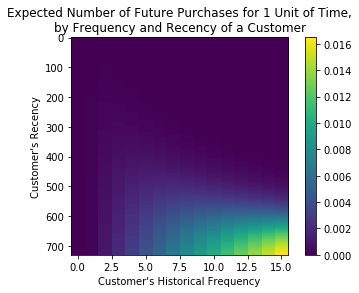

In [13]:
plot_frequency_recency_matrix(bgf); 

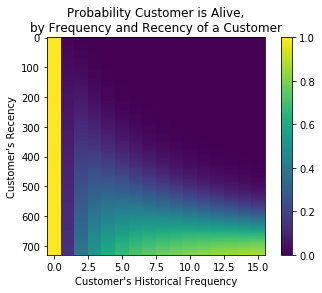

In [14]:
plot_probability_alive_matrix(bgf);

### Training a model and evaluating model performance

Next we want to evaluate the model to see how well it performs in the future. I'll split the data into a training (calibration) period and a holdout (observation) period, train the BG/NBD model and evaluate performance with four plots that Peter Fader outlines in [this talk](https://www.youtube.com/watch?v=guj2gVEEx4s) (@ 26:10). These plots are:

**1) Calibration period histogram**: does the model fit the training data? 

**2) Cumulative transaction plot**: does the model predict cumulative sales well?

**3) Incremental transaction plot**: does the model capture the overall trend in transactions? 

**4) Conditional expectations plot**: can the model predict the number of purchases a customer will make based on the training data? 

#### 1) Calibration period histogram

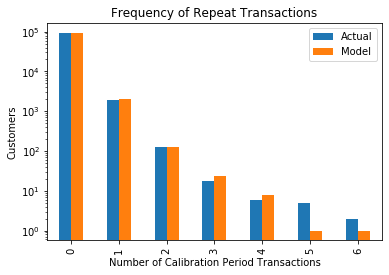

In [15]:
plot_period_transactions(bgf).set_yscale('log');

The model is fairly representative of the real data up until four repeat transactions. There are few customers who make more purchases.

#### 2) Cumulative transaction plot

In [16]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',
                                        calibration_period_end='2017-09-03',
                                        observation_period_end='2018-09-03' )

We can evaluate how the dataset works by plotting both of them. 

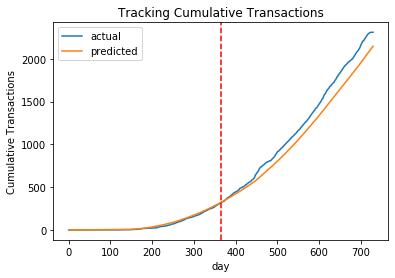

In [17]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf,transaction_data,'date','customer_unique_id',730,365);

The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model does a pretty swell job at predicting cumulative transactions.

#### 3) Incremental transaction plot

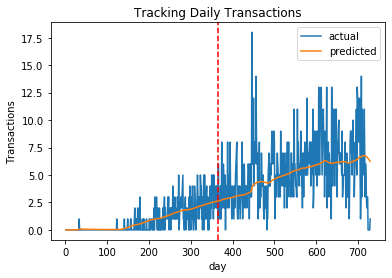

In [18]:
plot_incremental_transactions(bgf,transaction_data,'date','customer_unique_id',730,365);

This plot shows that the model does a decent job capturing general trends in the data. 

#### 4) Conditional expectations plot

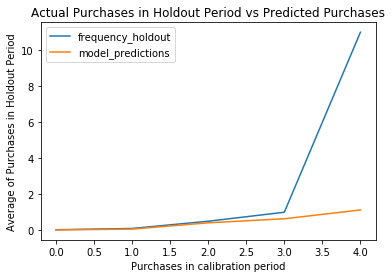

In [19]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

The model performs well up to three calibration period purchases, but diverges from the holdout data because of the distribution of the data.

In [20]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

Less than 1% of customers have made four or more purchases, so there's not much data for the BG/NBD model to learn about customers who have made many repeat transactions.

In practice, I would consider collecting more data if I were to proceed with modeling customer churn. But for learning purposes, it will still be a good exercise to predict churn.

### Modeling churn risk

The BG/NBD model assumes that death can only occur after a repeat purchase, since the customer leaving occurs during a purchase and the first purchase is reserved to signal a customer's birth. 

Because of this, customers with only one transactions will have a 100% probability of being alive, which is suspect. To account for this limitation, we'll only predict churn risk on customers who have made at least one repeat transaction. 

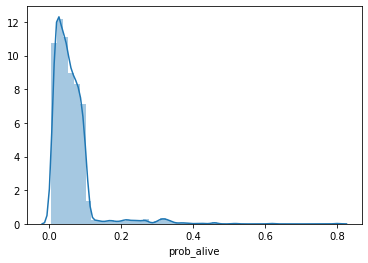

In [21]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);

From here, we can visualize customers based on the probability that they're "alive". Using domain knowledge we might be able to set a threshold for customers who probably have already churned, and also identify customers who are at risk for churning, but haven't yet disappeared.

Next, I would like to set a decision threshold for customer churn. This is an opportunity to inject personal expertise or talk with domain experts. Assume I speak with the sales and marketing managers, and we agree to consider a customer with <10% chance of being alive to have churned. 

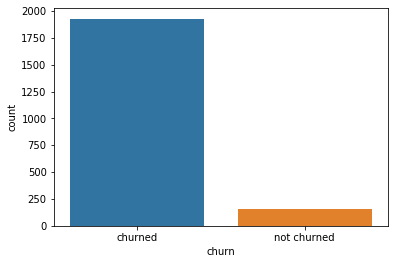

In [22]:
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);

A little over 92% of customers have churned, meaning that there's a lot of opportunity for improvement regarding retention.

We can assume that the customers who have churned are already lost. But what is interesting in a business setting is the customers who are at high risk for churn, but haven't churned yet. Later on, it might still be a good idea to apply different treatments to the churned group.

If I can identify them, maybe I can encourage the marketing team to target them with promotions. 

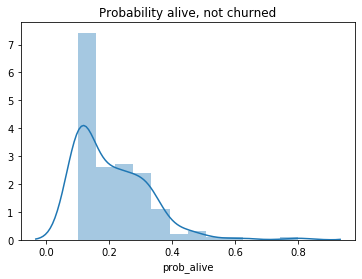

In [23]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');

It seems reasonable to bucket customers with 80% or more churn risk to be considered high risk for churn. 

In [24]:
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()

churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

In [36]:
df_example = df.sample(n = 10)
df_example.to_csv("../data/df_example.csv", index=False)

Now that I have these churn groupings, I can move forward and apply special treatments to these groups. Ideally there would be more data and a bigger population of high-risk customers. 

### Next steps

We've modeled churn risk in a non-contractual setting, and now have three customer segments--not churned, high risk, and churned. This could feed into a dashboard to give stakeholders a glimpse of "at-risk" customers. It also provides three different groups that we can run specific actions. Some ideas:

1) Reach out to churned customers to figure out why the left. 

2) Send different types of targeted emails and special offers to the high risk group. If the sample size of high risk customers is large enough, you could split off a few small treatment groups and compare how their retention and CLV change with different promotional or customer relationship strategies.

3) Determine the the highest value customers in the non-churn group, and serve them additional benefits to ensure that they remain loyal customers.

### Useful resources

* [What's a Customer Worth?](https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f) good starter tutorial on customer transactions and lifetime value with Lifetimes
* [Lifetimes documentation](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#)
* [Kaggle Customer Lifetime Value](https://www.kaggle.com/dhimananubhav/customer-lifetime-value/comments) same goal, same data, different model and analysis
* [Peter Fader CLV presentation](https://www.youtube.com/watch?v=guj2gVEEx4s) Peter Fader explains CLV... his overview of model performance graphs in the presentation is helpful
* [Robert Medri's Etsy CLV presentation](http://cdn.oreillystatic.com/en/assets/1/event/85/Case%20Study_%20What_s%20a%20Customer%20Worth_%20Presentation.pdf): slides titled "Acting on CLV" explain next action steps after you've modeled churn and CLV